In [34]:
from core.analysis import *
from core.metrics import *
from core.semcor_bert_pipeline import get_pos, save_embeds_with_wts
import numpy as np
import pandas as pd

## Data Prep

Reading in experimental data to see which words to run the model on

In [39]:
db = access_db()


ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

In [96]:
results, incl_users = get_results_elig_users(db, 'Self Consistency', 0.2)

/Users/sathvik/Desktop/Berkeley/Research/thesis/codebase/core/analysis.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['changes'] = user_changes['prevChanged'].values


In [10]:
test_repeat_lem_cnt = get_lemma_counts(results, incl_users, db)
test_words = test_repeat_lem_cnt[test_repeat_lem_cnt['num_trials'] > 10]['lemma']

## Modeling

In [12]:
model_data = {}
test_stats = []
incorrect = []
for w in test_words:
    model_results = logistic_cv(w, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                               use_masc = False, delim = '_')
    model_data[w] = model_results
    test_stats.append({"word": w, 'avg_f1': np.mean(model_results['f1']),
                         'avg_acc': np.mean(model_results['acc'])})    
    incorrect.append(misclassified_sentences(model_results, model_results['incorrect_indices']))

/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracies and F1 scores for Test Words for 5 fold Cross Validation 

In [69]:
model_perf = pd.DataFrame(test_stats).sort_values('avg_f1', ascending = False)

## Analysis of Classifier Performance

In [70]:
semcor_entropy = pd.read_csv('../data/expt_semcor_types.csv')
semcor_entropy.drop("Unnamed: 0", axis = 1, inplace = True)
semcor_entropy['word'] = semcor_entropy['Lemma'].apply(lambda l: l.replace('.', '_'))
with_entropy = model_perf.merge(semcor_entropy, on = 'word')

Text(0.5, 1.0, 'Entropy and Average F1 Score')

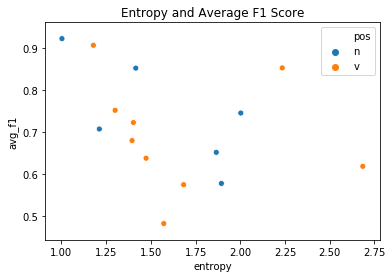

In [75]:
sns.scatterplot(x = 'entropy', y = 'avg_f1', hue = 'pos', data = with_entropy)
plt.title("Entropy and Average F1 Score")

In [77]:
model_perf['num_senses'] = model_perf['word'].apply(get_num_senses, args = [db])
model_perf['pos'] = model_perf['word'].apply(get_pos, args = ['_'])


Text(0.5, 1, 'Number of Senses and Average F1 Score')

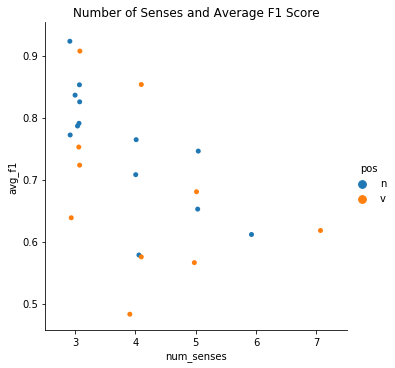

In [93]:
sns.catplot(x = 'num_senses', y = 'avg_f1', hue = 'pos', data = model_perf)
plt.title("Number of Senses and Average F1 Score")

## Confusion Matrices

We plot the results from the experiment with the cosine similarity of the BERT centroids, as well as the confusion matrices for the classification task. 

In [14]:
import seaborn as sns

In [15]:
from matplotlib.backends.backend_pdf import PdfPages

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


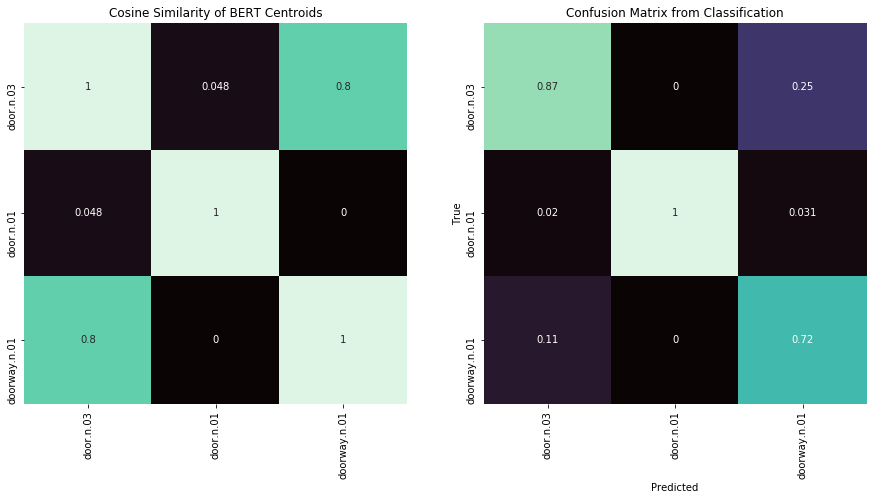

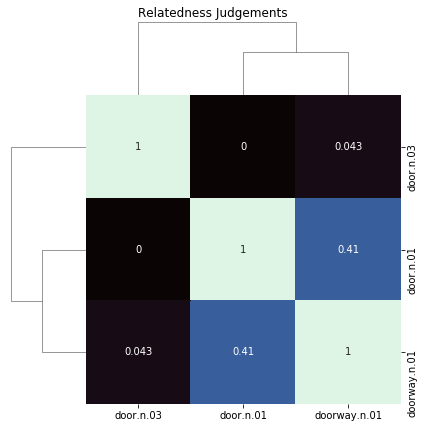

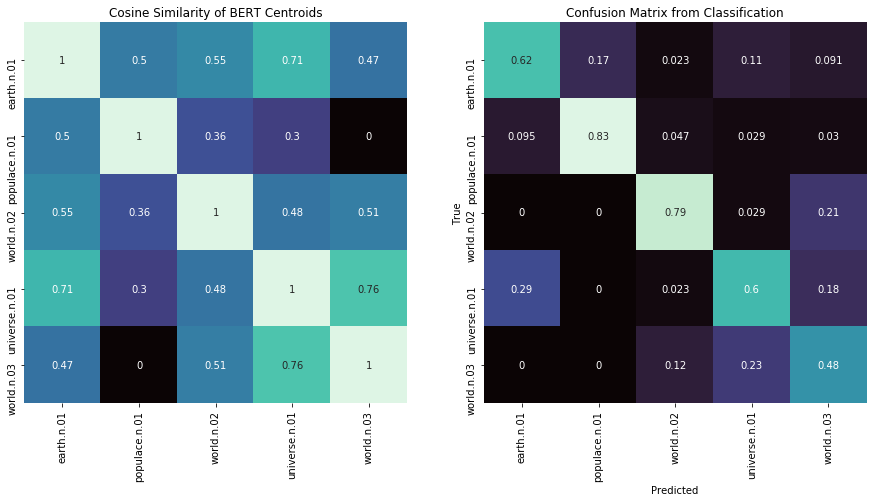

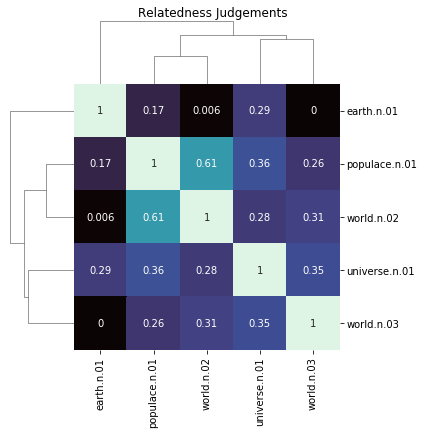

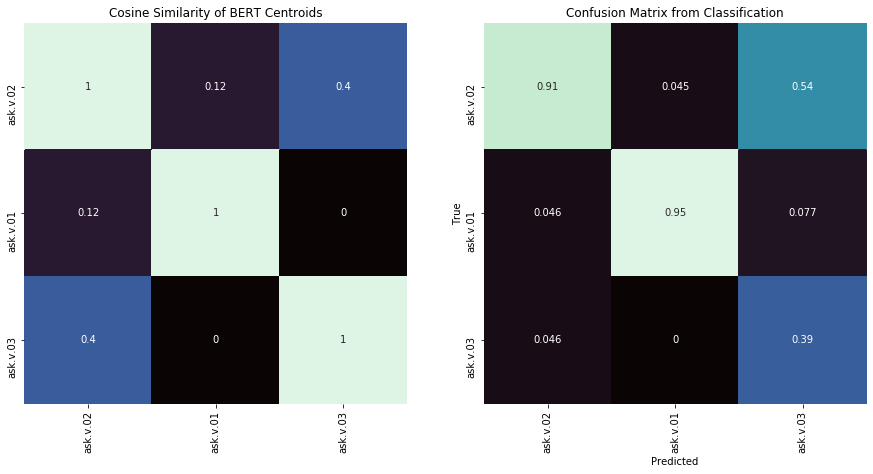

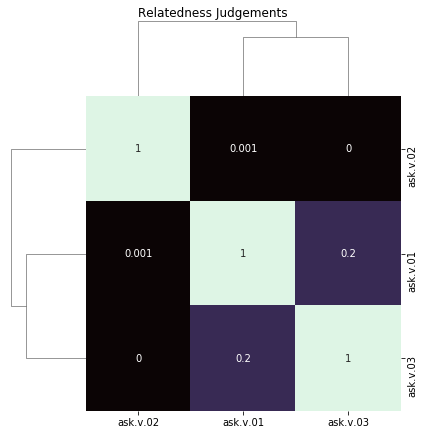

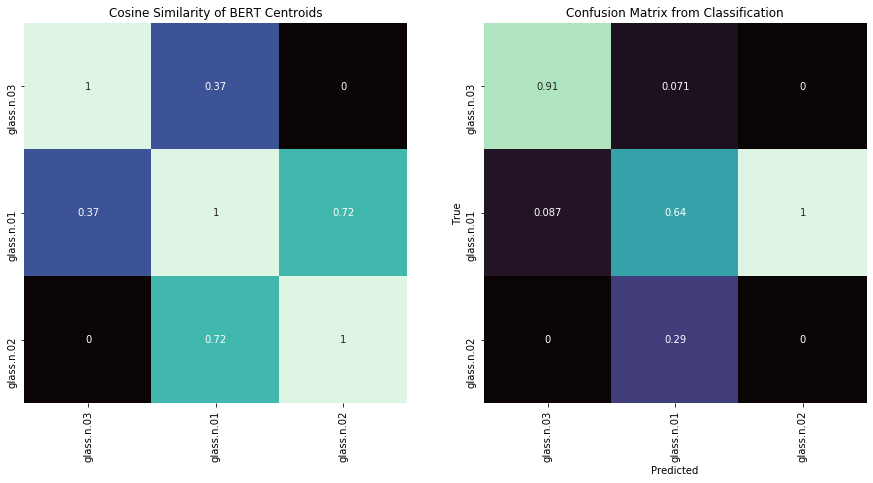

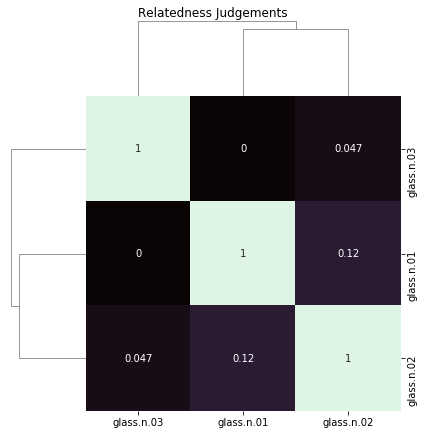

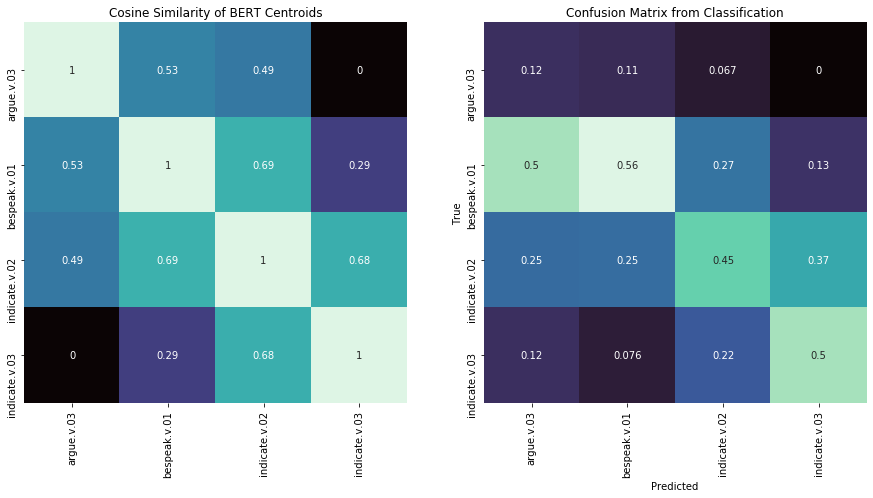

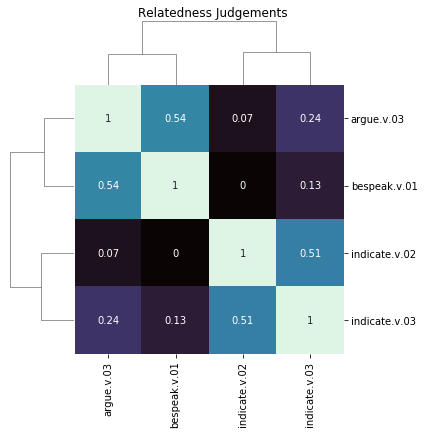

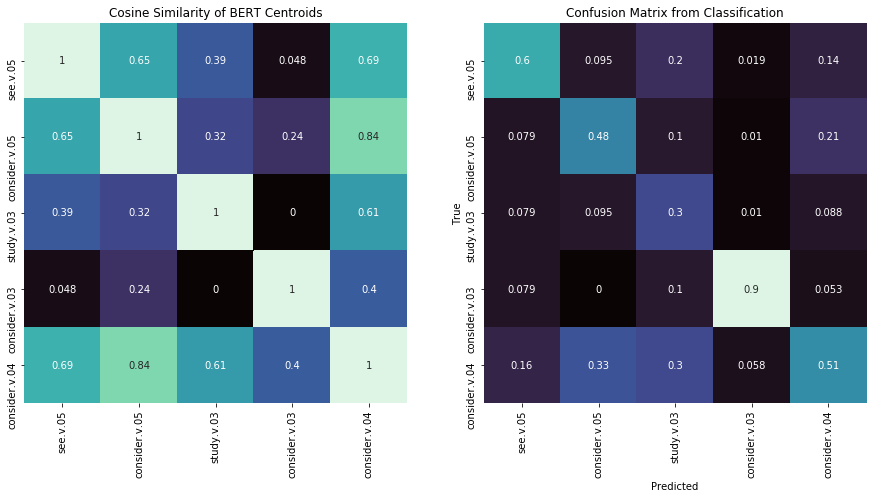

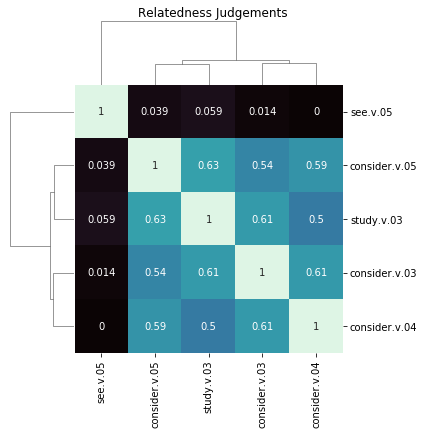

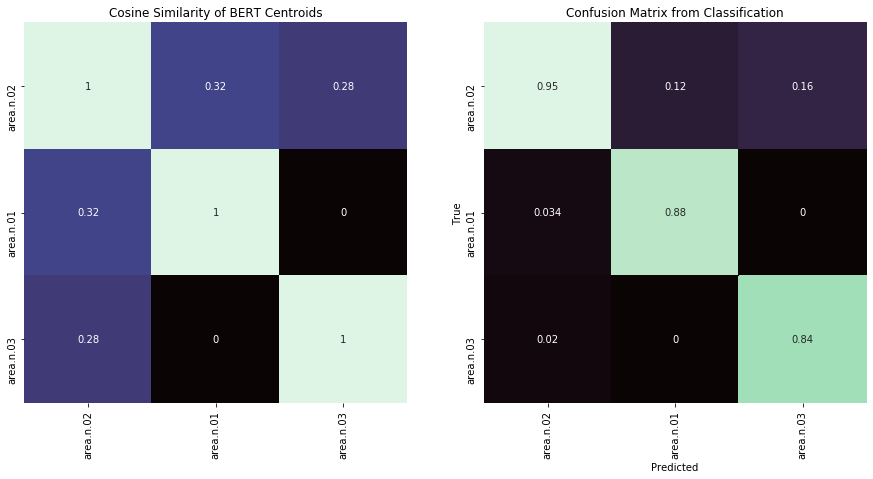

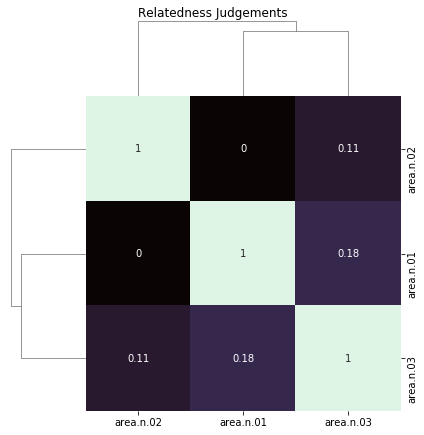

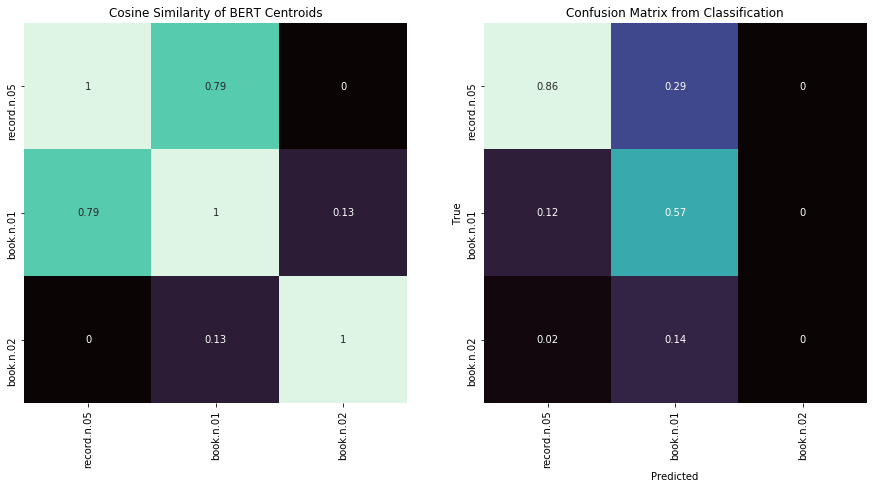

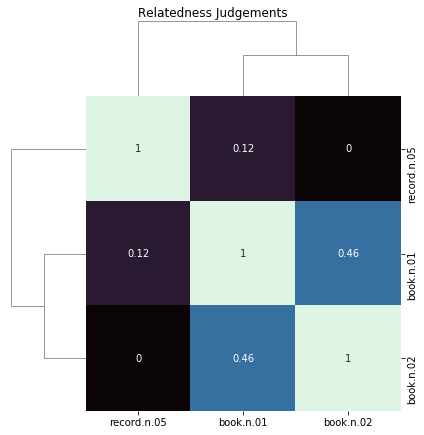

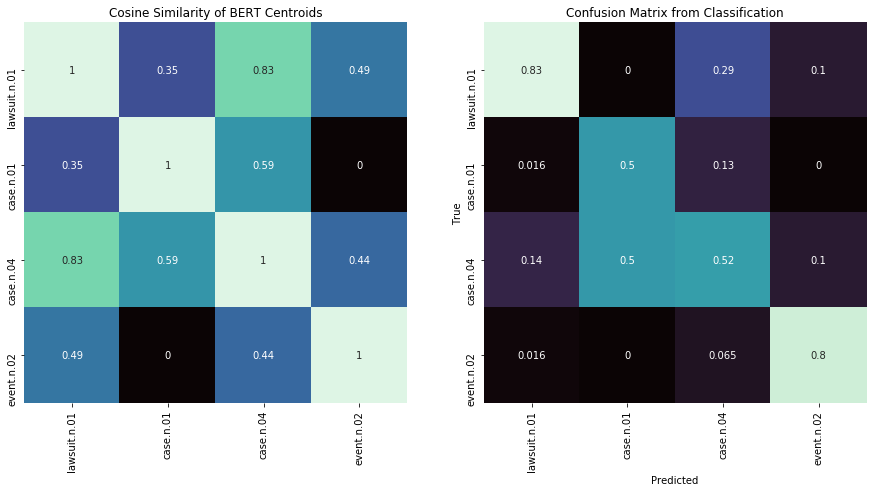

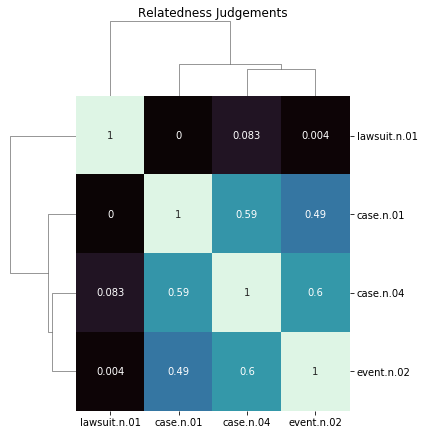

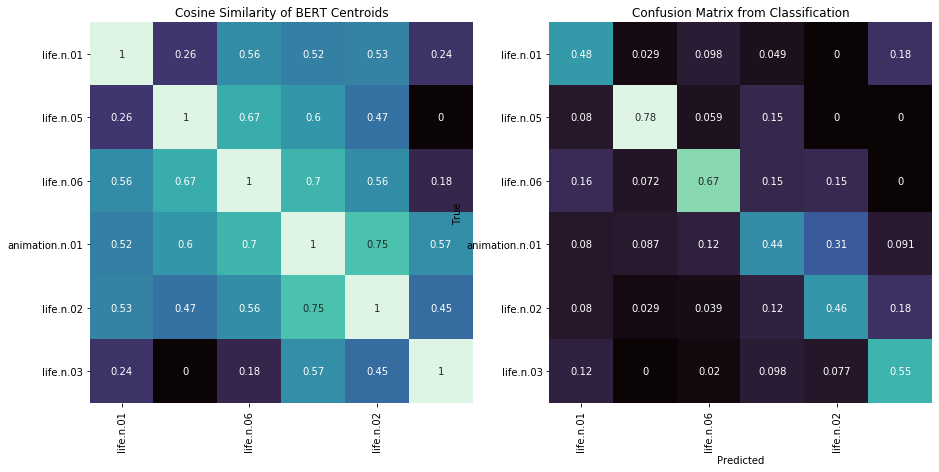

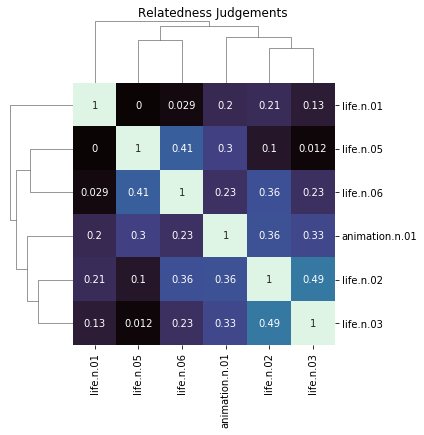

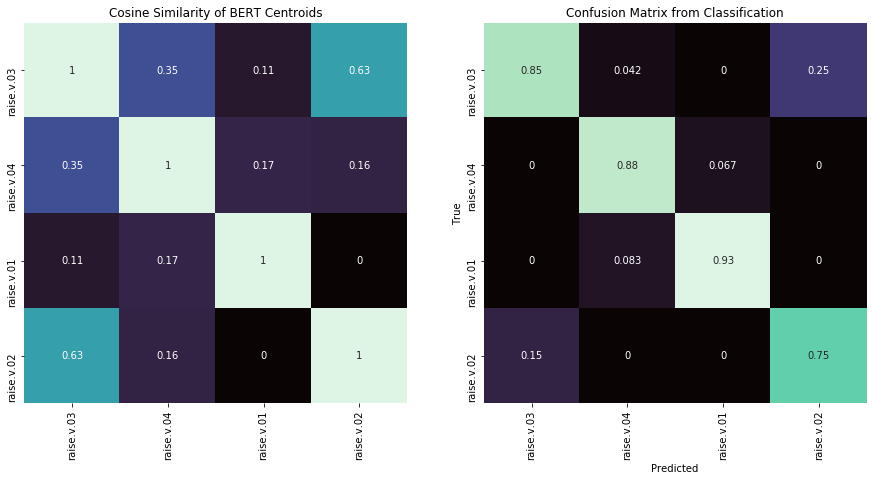

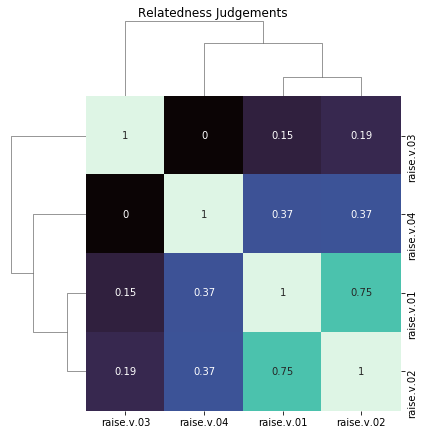

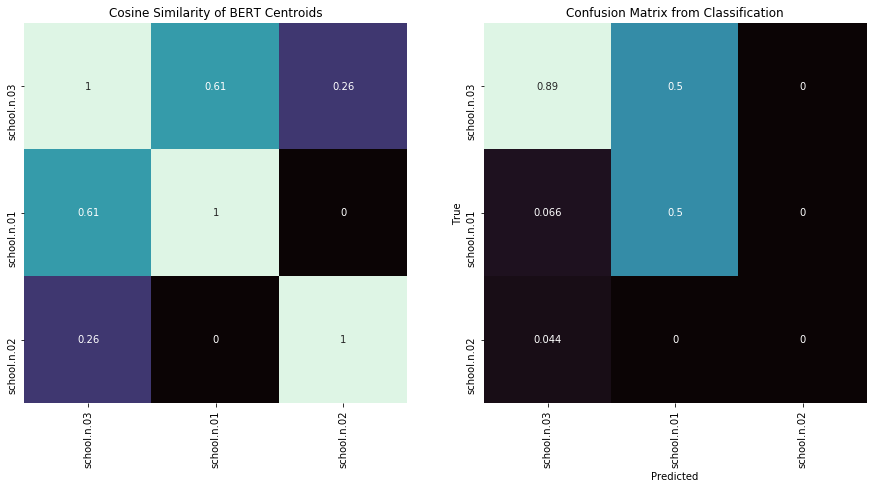

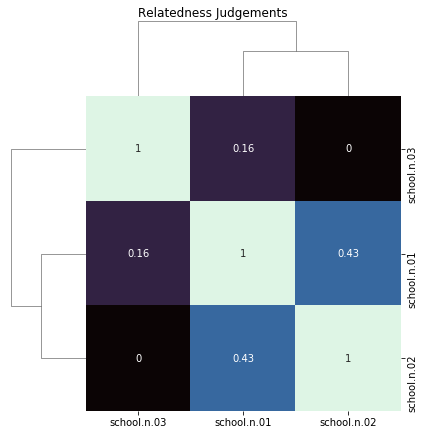

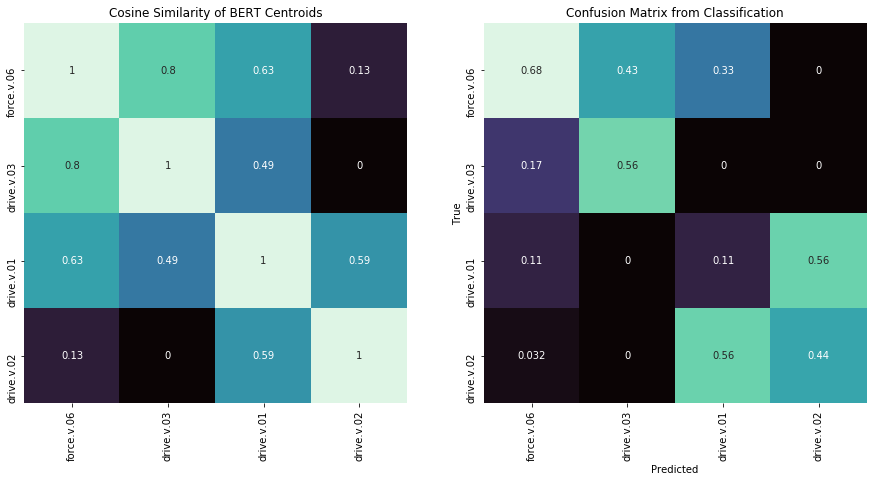

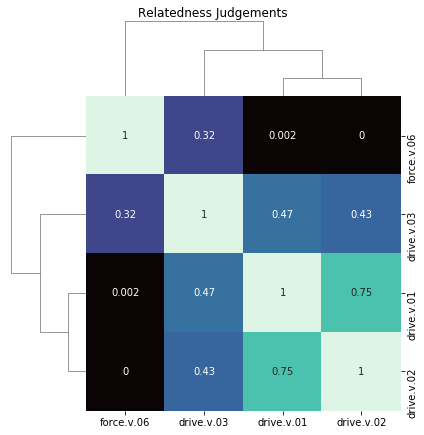

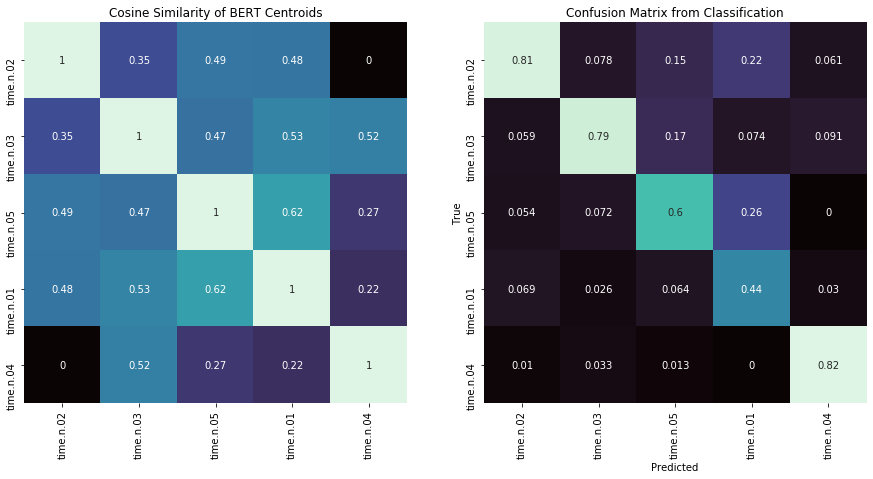

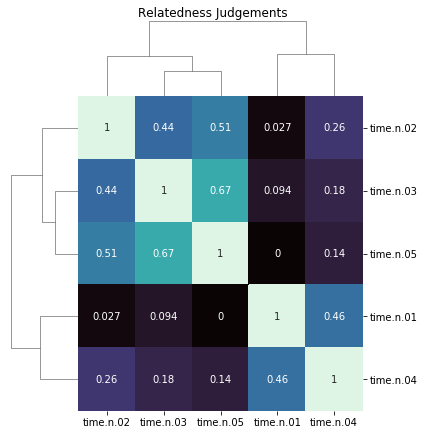

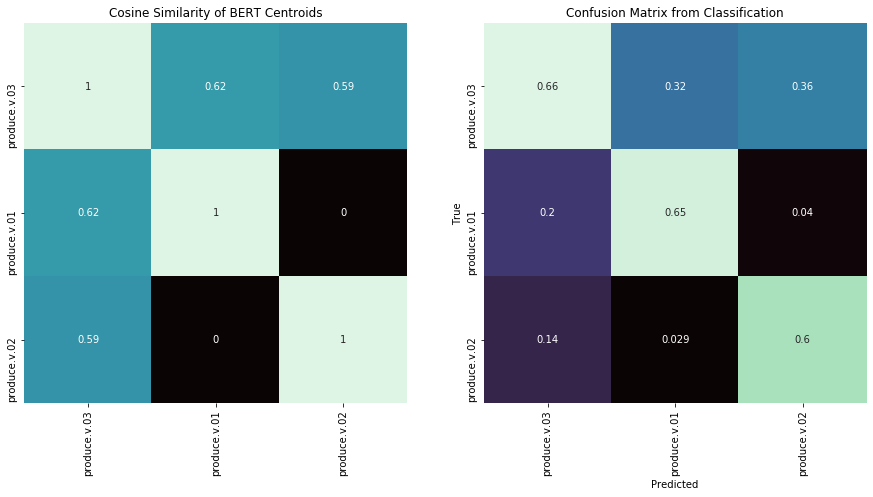

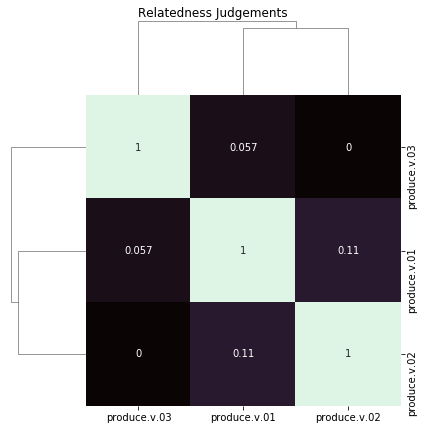

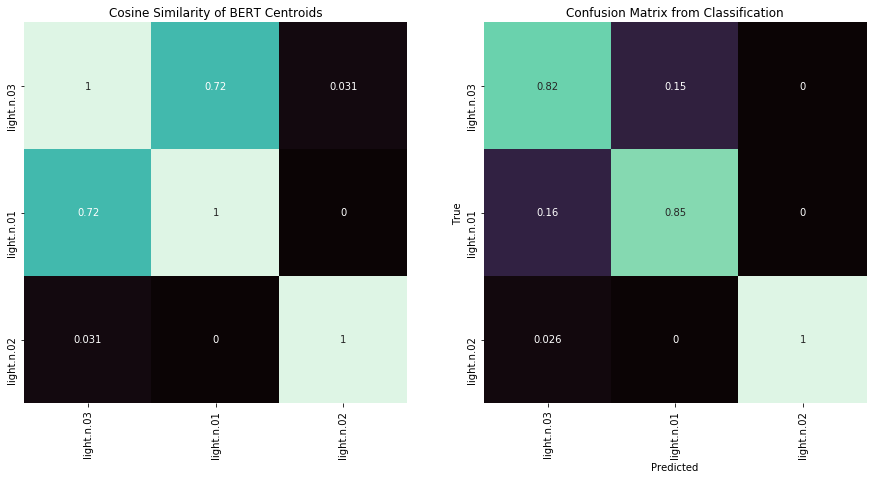

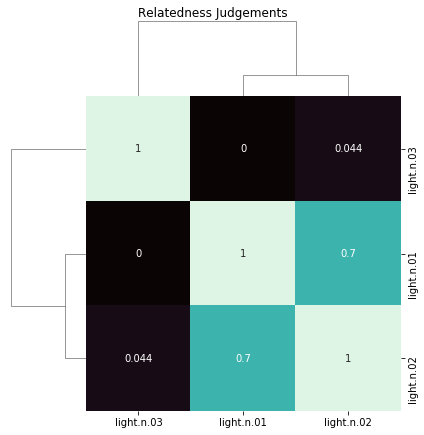

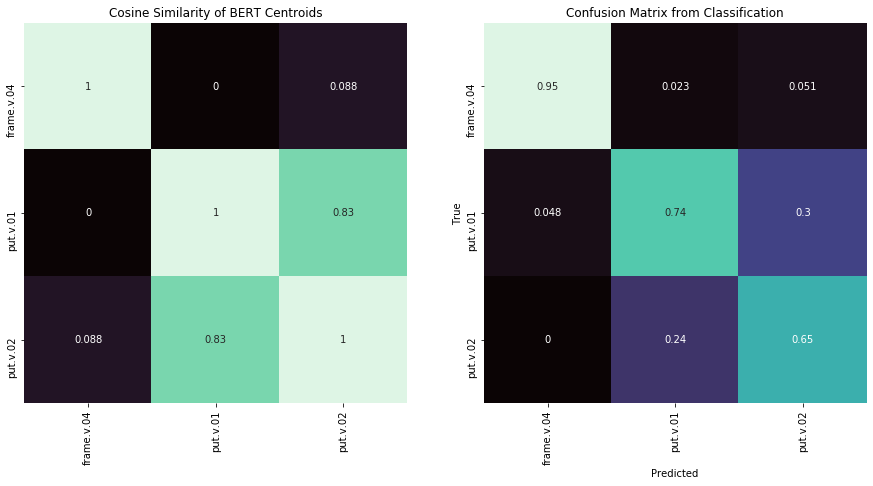

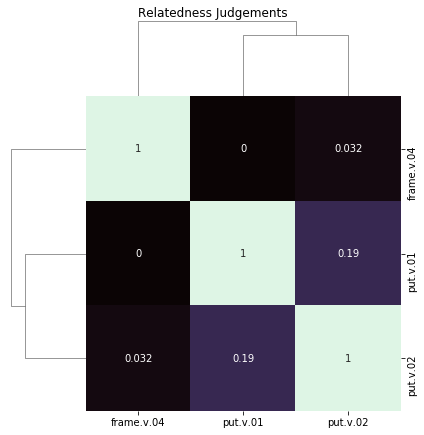

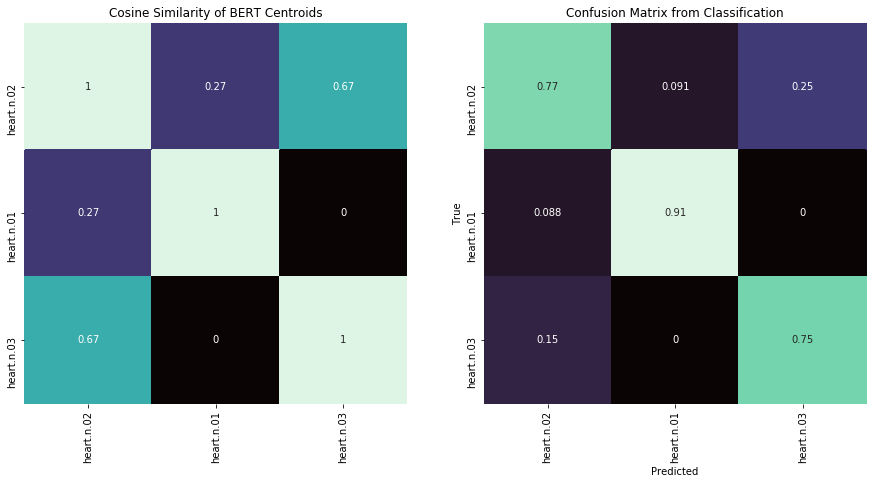

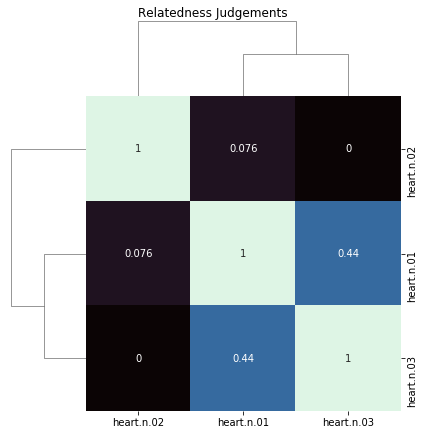

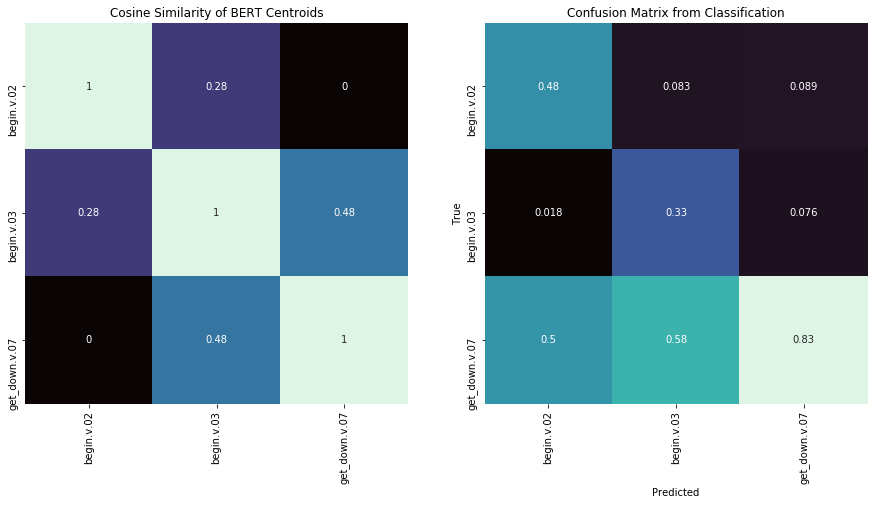

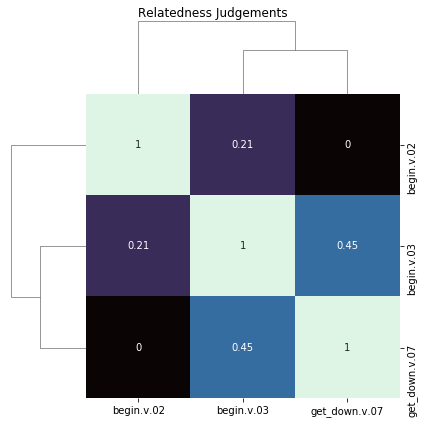

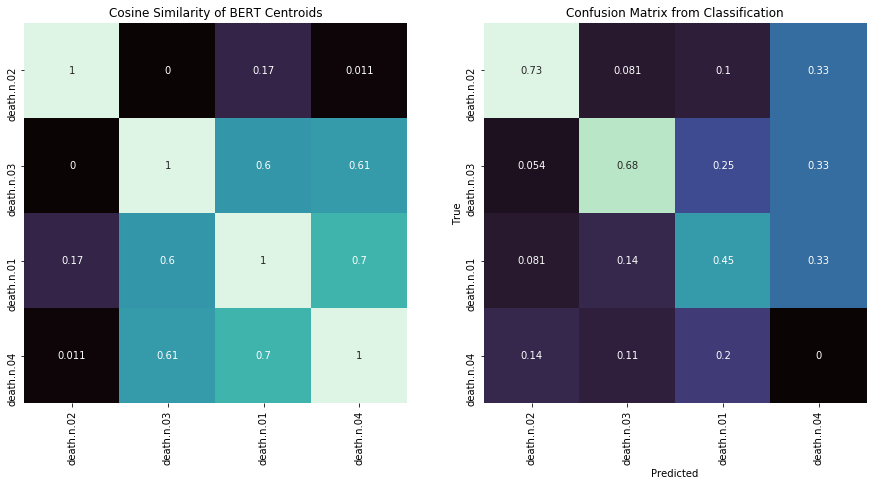

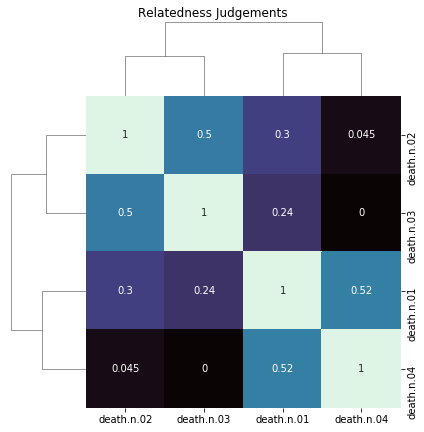

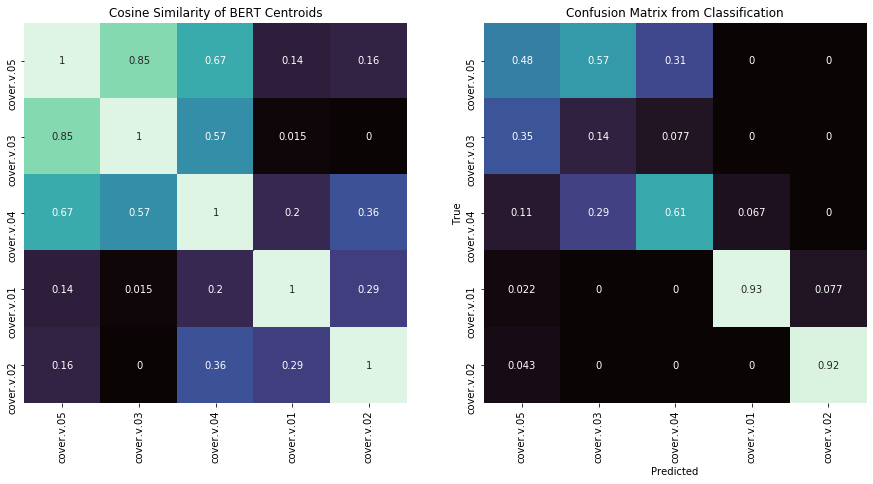

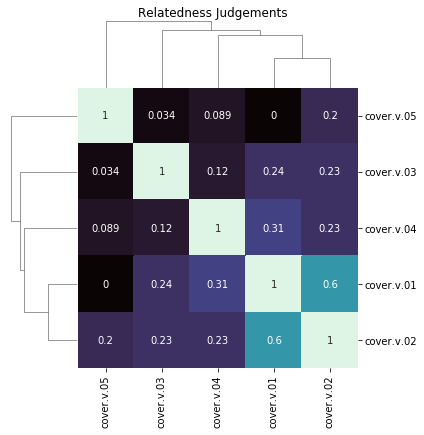

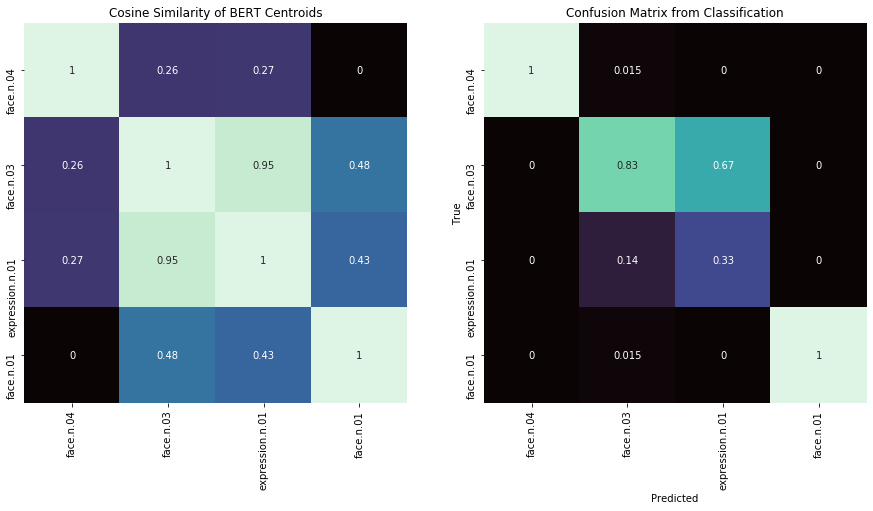

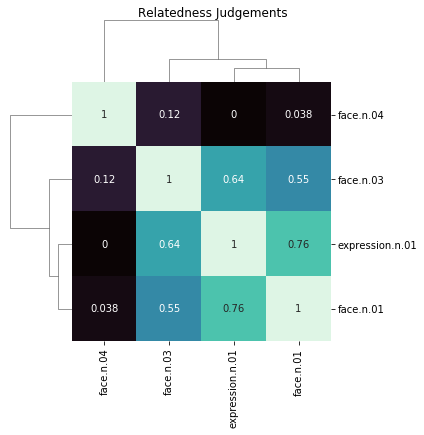

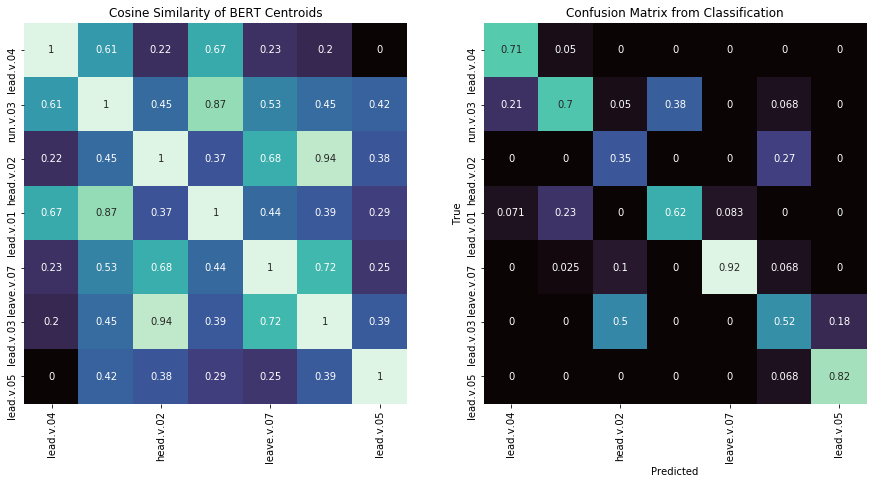

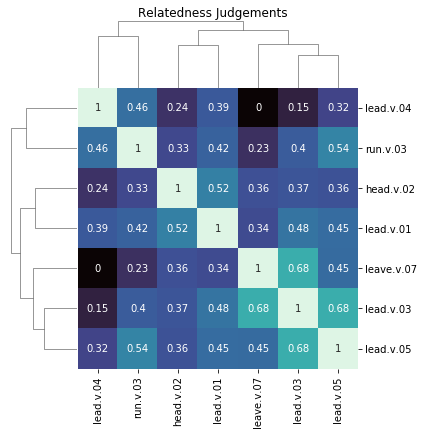

In [184]:
matrices = {w: {} for w in test_words}

for w in test_words:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2.4, 7))

    avg_reported = get_test_result_data(results, w, incl_users)
    matrices[w]['expt'] = avg_reported
    senses = np.array([fb_to_local(s) for s in get_senses(db, w.replace('.', '_'))])
    cg = sns.clustermap(mtx_to_df(1 - avg_reported, senses), cmap = 'mako', annot = True, figsize = (6, 6),
                           cbar_pos = None)
    cg.fig.suptitle('Relatedness Judgements', y = 1)

    reordered_sense_indices = cg.dendrogram_row.reordered_ind

    word, pos = w.split("_")
    bert_cs, sense_names = cosine_sim_mtx(word, pos, sel_senses = senses,
                                         corpus = 'semcor', use_masc = False)
    bert_cs = normalize_cos_dist(bert_cs)
    matrices[w]['bert'] = bert_cs
    bcs_fig = sns.heatmap(mtx_to_df(1 - bert_cs, senses, reorder = reordered_sense_indices),
                          ax = ax1, annot = True, cmap = 'mako', cbar = False)
    bcs_fig.set_title("Cosine Similarity of BERT Centroids")

    word_matrices = model_data[w]['confusion_matrices']
    agg_confusion = np.sum(np.asarray(word_matrices), axis = 0)
    agg_confusion = np.nan_to_num(agg_confusion / np.sum(agg_confusion, axis = 0))
    conf_fig = sns.heatmap(mtx_to_df(agg_confusion, senses, reorder = reordered_sense_indices),
                           cmap = 'mako', ax = ax2, annot = True, cbar = False)
    conf_fig.set_title("Confusion Matrix from Classification")
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("True")
    fig.subplots_adjust(right = 5)
    

## Comparison of Embeddings with Nonzero Weights to Experimental Data

Saving values at nonzero weights

In [18]:
from core.semcor_bert_pipeline import save_embeds_with_wts

In [ ]:
for w in model_data.keys():
    results = model_data[w]
    save_embeds_with_wts(results['data'], results['labels'], results['weights'], w.replace('_', '.'))